In [ ]:
from google.colab import drive #import google colab library
drive.mount('/content/drive')  #drive the google drive to get the images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os               #import os for file calling
import tensorflow as tf #import tensorflow for training later 
#Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
#this code is to help the user choose which style they want to use
STYLE_IMAGE_NAME = 'Juan_Luna' #@param ['Vincent_Van_Gogh', 'Juan_Luna']
#this is where the urls are stored based on  the name of the parameter
corresponding_url = {
    'Vincent_Van_Gogh': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
    'Juan_Luna': 'https://upload.wikimedia.org/wikipedia/commons/c/cb/Spolarium.jpg'
}
#this this connects the style image name and the url that was used earlier
style_image_path = tf.keras.utils.get_file(STYLE_IMAGE_NAME, corresponding_url[STYLE_IMAGE_NAME])

65218/65218 [==============================] - 0s 1us/step


In [ ]:
import IPython.display as display #library used for interactive computing

import matplotlib.pyplot as plt   #libraries used for plotting and visualization
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np #library for linear algebra
import PIL.Image   #library used for image processing
import time        #library to control time and represent it in code
import functools   #library used for high order functions
#defines the image converter and converts into a numpy array
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)
#directory of the base image and style image
base_image_path = "/content/drive/MyDrive/Homework 2/Base Photo/Basephoto1.jpg"
style_path = style_image_path

In [ ]:
#defines the loading of an image and reading the file in the directory
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
#scales the shape and dimension of the image
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
#defines the function to display the images
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

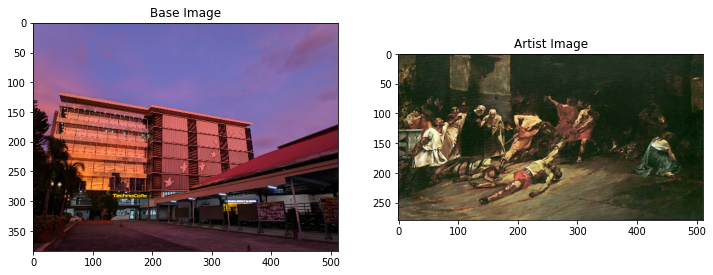

In [ ]:
#plots base image and the artist image
base_image = load_img(base_image_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(base_image, 'Base Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Artist Image')

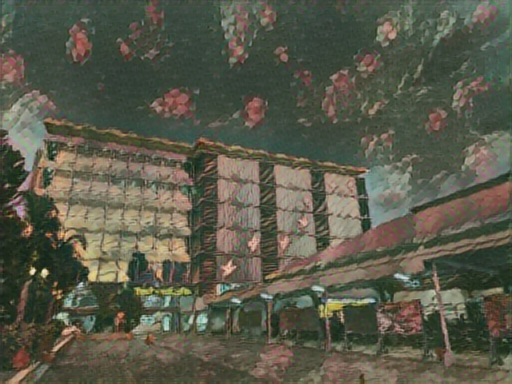

In [ ]:
import tensorflow_hub as hub #import the library to use the tensorflow hub and import the model used from the hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(base_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
#processes the image and defines the VGG model to be used in testing and training
x = tf.keras.applications.vgg19.preprocess_input(base_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
#predicts the top 5 vgg predictions
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('cinema', 0.2946153),
 ('library', 0.0405019),
 ('fire_engine', 0.039418656),
 ('planetarium', 0.037683703),
 ('freight_car', 0.032800376)]

In [ ]:
#the model to be used in training and testing
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name) #prints the layers in the vgg


input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
#determines which layers will include the base image layers and the style image layers
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
#defines the vgg layers based on the parameters on the previous code
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  #Load the vgg model, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
#extracts the layers where the style image layers were included based on earlier
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 279, 511, 64)
  min:  0.0
  max:  817.9992
  mean:  16.510382

block2_conv1
  shape:  (1, 139, 255, 128)
  min:  0.0
  max:  3935.7756
  mean:  94.86971

block3_conv1
  shape:  (1, 69, 127, 256)
  min:  0.0
  max:  5875.8433
  mean:  97.80698

block4_conv1
  shape:  (1, 34, 63, 512)
  min:  0.0
  max:  12092.26
  mean:  386.80365

block5_conv1
  shape:  (1, 17, 31, 512)
  min:  0.0
  max:  1938.3357
  mean:  31.842638



In [ ]:
#defines the new matrix coputed using the einsum function in tensorflow
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
#this entire code block returns the matrix ealier, it includes the style image layer matrix and the base image layer matrix
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
#continuation of the StyleContent Model
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(base_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0043622446
    max:  18652.799
    mean:  720.94574

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  142128.67
    mean:  19088.027

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.069893636
    max:  477494.84
    mean:  19772.678

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6317187.5
    mean:  304248.03

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  109087.48
    mean:  2228.7

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1108.4445
    mean:  16.152258


In [ ]:
#this optimizes the image to prepare it for the style transfer
style_targets = extractor(style_image)['style']
content_targets = extractor(base_image)['content']

image = tf.Variable(base_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [ ]:
#determines the loss of the style transfer
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
#this optimizes the image even more
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

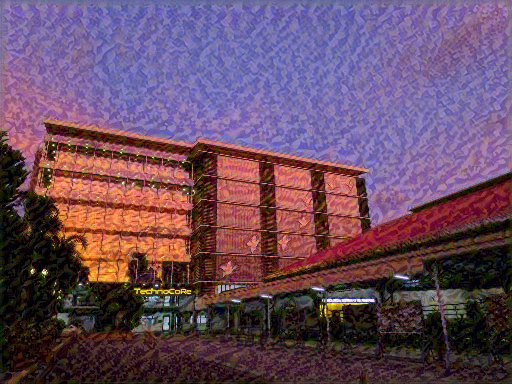

In [ ]:
#to test is everything is working
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

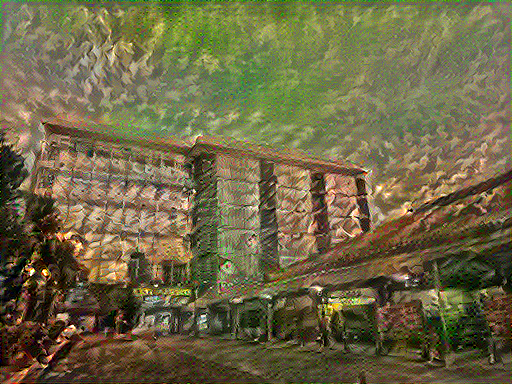

Train step: 500
Total time: 3194.9


In [ ]:
#testing and training of the model and application of the neural transfer
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

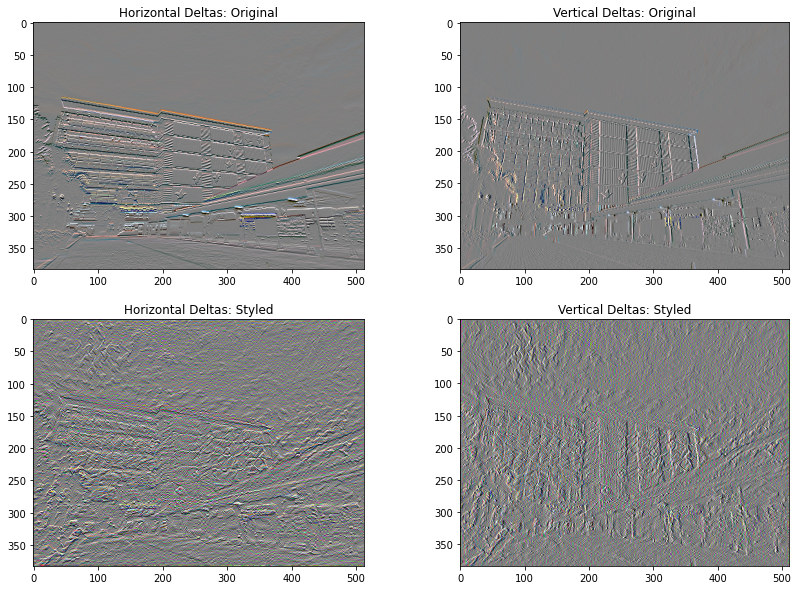

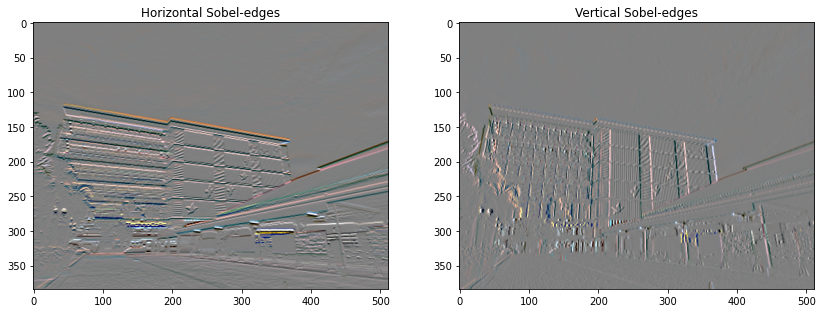

In [ ]:
#determines the loss and plots the horizontal and vertical aspects of the original and transfered image
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(base_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(base_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
#determines the loss of the image and displays the loss 
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()
tf.image.total_variation(image).numpy()

array([104117.66], dtype=float32)

In [ ]:
#optimizes the model even more by applying the new loss values and applying them
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(base_image)

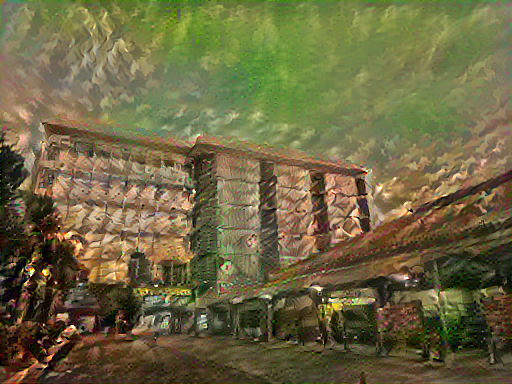

Train step: 500
Total time: 3250.3


In [ ]:
#testing and training of the model and application of the neural transfer on the new optimized parameters
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>